The first function sums the pahses to make intensity in accordance with the formula $ I(t)$ = $ \beta E_0^2 \sum_{j} \sum_{k} e^{i(\phi_j(t) - \phi_k(t)} $ Actually it just does the real part so it is cosine instead of $e^i$

This function moves every particle in accordance with the predicted gaussian pattern.

In [3]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

def intensitymaker(phases):
    #given an array of phases, returns electrical intensity
    summedphase = 0
    for i in range(500):
        for k in range(500):
            x = phases[i] - phases[k]
            sumone = math.cos(x) #maybe should not be cosine?
            summedphase = sumone +summedphase

    constants = 1 #needs calculation. set as one
    intensity = constants * summedphase
    return(intensity)
    


In [4]:
def timestep(r):
    #returns x y and z positions after a time step
    sd = math.sqrt(2 * 1.38064852*10**-23 * 293 * 1/20 / (3 * math.pi * .001 * .00001)) #2 kb T / 3 pi eta D
    for i in range(len(r[0])):
        r[0][i] += np.random.normal(0,sd) #* 1/20 #need to calculate standard deviation here
        r[1][i] += np.random.normal(0,sd) #* 1/20
        r[2][i] += np.random.normal(0,sd) #*1/20
    return(r)

The phasemaker function, when given the displacement of the particles $r$ and the angle $\theta$ (the angle from the laser from which the displacement is measured) will. First we establish the magnitude of $K$ by $K = \frac{2 \pi}{\lambda} \sin(\theta/2)$. From that magnitude, the component vectors can be found by multiplying $K$ by $\cos(\theta)$ and by $\sin(\theta)$, and we put those component vectors into an array so we can get the vector $\boldsymbol{K}$. The dot product $\boldsymbol{K} \cdot \boldsymbol{r} = \phi$, so we use this function to create an array of the phase of light scattered from each particle. An more in depth explanation of the math behind this can be found in the paper

In [5]:

def phasemaker(r,theta):
    #given positions of particles relative to their starting ppositions returns phases
    #hold on, I do not think I need z_pos? Because phase is dot product of vector K and r, and the z component ok K is 0
    #so K is K = kx + ky, where k is lambda/2pi. K dot r is kx*x +ky*y +0*z
    constant = 2* math.pi / 0.000000635 #actually 2 pi over wavelength, but I will calculate later
    K = constant * math.sin(theta/2)
    k = np.array([K * math.cos(theta), K * math.sin(theta), 0])
    phase = []
    for i in range(len(r[0])):
        #vector = np.array([r[0][i],r[1][i],r[2][i]])
        #phase_one = np.dot(k,vector)
        
        phase_one = r[0][i] * constant+ r[1][i] *constant
        phase.append(phase_one)
    return(phase)

The next function autocorrelates the intensity and produces a graph of the autocorrelated intensity. 

In [6]:
from pandas.compat import lmap

def autocorrelation_plot(series, ax=None, **kwds):
    """
    This is a sllightly edited version of the pandas autocorrelation plot obtained from
    https://github.com/pandas-dev/pandas/blob/v0.24.1/pandas/plotting/_misc.py#L600
    -------------
    Autocorrelation plot for time series.
    Parameters:
    -----------
    series: Time series
    ax: Matplotlib axis object, optional
    kwds : keywords
        Options to pass to matplotlib plotting method
    Returns:
    -----------
    ax: Matplotlib axis object
    """
    import matplotlib.pyplot as plt
    n = len(series)
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) *
                (data[h:] - mean)).sum() / float(n) / c0
    x = np.arange(n) + 1
    y = lmap(r, x)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axhline(y=z95 / np.sqrt(n), color='grey')
    ax.axhline(y=0.0, color='black')
    ax.axhline(y=-z95 / np.sqrt(n), color='grey')
    ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.plot(x, y, **kwds)
    if 'label' in kwds:
        ax.legend()
    ax.grid()
    return ax,x,y


def autocorrelation(intensities, time):

    
    #correlated =np.convolve(intensities,intensities, mode = 'full')
    #corr = np.delete(correlated, np.arange(0,50,1))
    #plt.plot(time, correlated)
    plot,x_data,y_data = autocorrelation_plot(intensities)
    plt.show()
    return x_data,y_data
    



This next function does power watever

In [7]:
from __future__ import division

def powerspectrum(intensities):
    #https://stackoverflow.com/questions/15382076/plotting-power-spectrum-in-python
    ps = np.abs(np.fft.fft(intensities))**2 #this is just the calculation of the power spectrum
    freqs = np.fft.fftfreq(intensities.size, .05) #this gives the frequencies based on the distance in time between datapoints
    freqs = np.delete(freqs, 0)
    idx = np.argsort(freqs) #this gives the index that would sort the frequncies
    
    ps = np.delete(ps, 0)
    
    plt.plot(freqs[idx],ps[idx]) #makes the plot of sorted frequency and power
    return ps, freqs
    



In [57]:
def calculate_gamma(x,y,xauto,yauto):
    '''gamma from autocorrelation'''
    
    Alpha = yauto[-1]
    
    Beta = yauto[0] - Alpha
    
    ggama = np.array([])
    for i in range(len(xauto)-1):
        if xauto[i] > 0:
            th = abs(yauto[i]-Alpha)/Beta
            ggama =np.append(ggama,math.log(th)/-xauto[i+1])
    ggamma_avg = np.average(ggama)
    
    '''Gamma from power spectrum'''
    lowest = y[0]
    for i in range(len(y)):
        if y[i] < lowest:
            lowest = y[i]
    scaling = y[0] - lowest
    gamma = (abs(x) / np.sqrt(abs((scaling/y - lowest)-1)))
  
    gammas = np.array([])
    for i in range(len(gamma)):
        if gamma[i] < 10**99 :
            gammas = np.append(gammas, gamma[i])
    
    gamma_avg = np.average(gammas)
    sd_gamma = np.std(gammas)
    
    
    '''now i am going to try and calculate diameter from gamma'''
    
    diameter1 = 32 * math.pi * 1.38064852*10**-23 * 293 / (3 * 1.333 * (0.000000635)**2 ) * math.sin(math.sin(math.pi/4)) / gamma_avg
     
    diameter2 = 32 * math.pi * 1.38064852*10**-23 * 293 / (3 * 1.333 * (0.000000635)**2 ) * math.sin(math.sin(math.pi/4)) / ggamma_avg
    
    print(gamma_avg, sd_gamma, diameter1, diameter2)


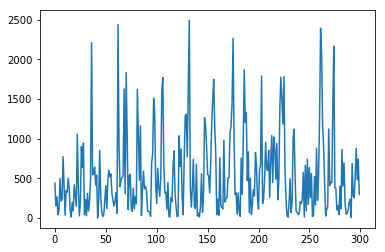

In [41]:

times = np.arange(0,300,1) 
position_vectors = np.array([np.zeros(500),np.zeros(500),np.zeros(500)])
intensity_time = np.array([])
for i in range(100):
    #phases = phasemaker(position_vectors, math.pi /2)
    #intense  = intensitymaker(phases)
    ##intensity_time = np.append(intensity_time, intense)
    timestep(position_vectors)
for i in range(300):
    phases = phasemaker(position_vectors, math.pi /2)
    intense  = intensitymaker(phases)
    intensity_time = np.append(intensity_time, intense)
    timestep(position_vectors)
useful_intensity = np.delete(intensity_time, 0)
plt.plot(times, intensity_time )
plt.show()

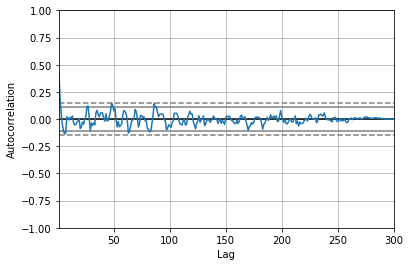

In [42]:
xauto,yauto = autocorrelation(intensity_time, times)

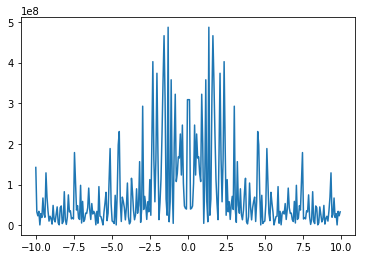

In [43]:
power, frequency = powerspectrum(intensity_time)
plt.show()


In [58]:
calculate_gamma(frequency, power, xauto, yauto)

0.00648171605326 0.00371739969659 2.52774033157e-05 4.07977362903e-06


NameError: name 'inf' is not defined

In [333]:

position_vectors = np.array([np.zeros(100),np.zeros(100),np.zeros(100)])

intensity_time = np.array([])
time = np.array([])


 

#intensity_time[0] = 0    
#x = np.correlate(intensity_time, intensity_time)
#plt.acorr(intensity_time)
#plt.plot(time, intensity_time)
#plt.show()

In [236]:
l = 0
m = 0
for i in range(100):
    r = np.random.normal(0,1)
    if r > 0:
        l +=  1   
    if r < 0:
        m += 1
if l > m:
    print("pos")
if l < m:
    print('neg')
if l == m:
    print('0')

0


In [266]:
math.cos(math.pi)

-1.0

In [32]:
?np.convolve

In [ ]:
times = np.arange(0,100,1)    
position_vectors = np.array([np.zeros(100),np.zeros(100),np.zeros(100)])
intensity_time = np.array([])
for i in range(100):
    phases = phasemaker(position_vectors, math.pi /2)
    intense  = intensitymaker(phases)
    intensity_time = np.append(intensity_time, intense)
    timestep(position_vectors)  

#autocorrelation(intensity_time, times)